__Time Series Analysis and Forecastiong of Technology Sales of a store__

There are several categories in superstore data. We take tecnolgy items sales (such as calculator, watch etc.) for time series analysis and forecasting.

__Exploring Data__

In [1]:
# Required imports

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel('Superstore.xls')
technology = df.loc[df['Category'] == 'Technology']

In [3]:
technology.shape

(1847, 21)

In [4]:
technology.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,2016-01-16,2016-01-20,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737


In [5]:
technology['Order Date'].min(), technology['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

So, we have very good 4 years of sales data for analysis.

__Data Processing__

We need only order date and sales values to anlyse. So, we can easily remove unwanted columns.

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)

technology = technology.sort_values('Order Date')

technology.isnull().sum()

Order Date    0
Sales         0
dtype: int64

It's look no missing values.

__Indexing with Time Series Data__

In [7]:
# group data by daily sales
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()

technology = technology.set_index('Order Date')
technology.index

DatetimeIndex(['2014-01-06', '2014-01-09', '2014-01-13', '2014-01-15',
               '2014-01-16', '2014-01-20', '2014-01-26', '2014-02-01',
               '2014-02-02', '2014-02-06',
               ...
               '2017-12-18', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [8]:
y = technology['Sales'].resample('MS').mean()

# check the data of 2016 
y['2016':'2016']

Order Date
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
Freq: MS, Name: Sales, dtype: float64

__Visualizing Technology Sales Time Series Data__

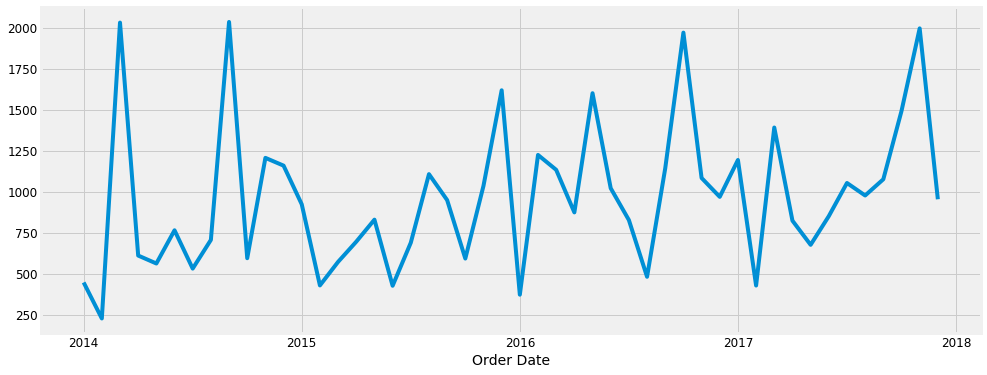

In [9]:
y.plot(figsize=(15,6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern (except 2014), such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

To have a look, we can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

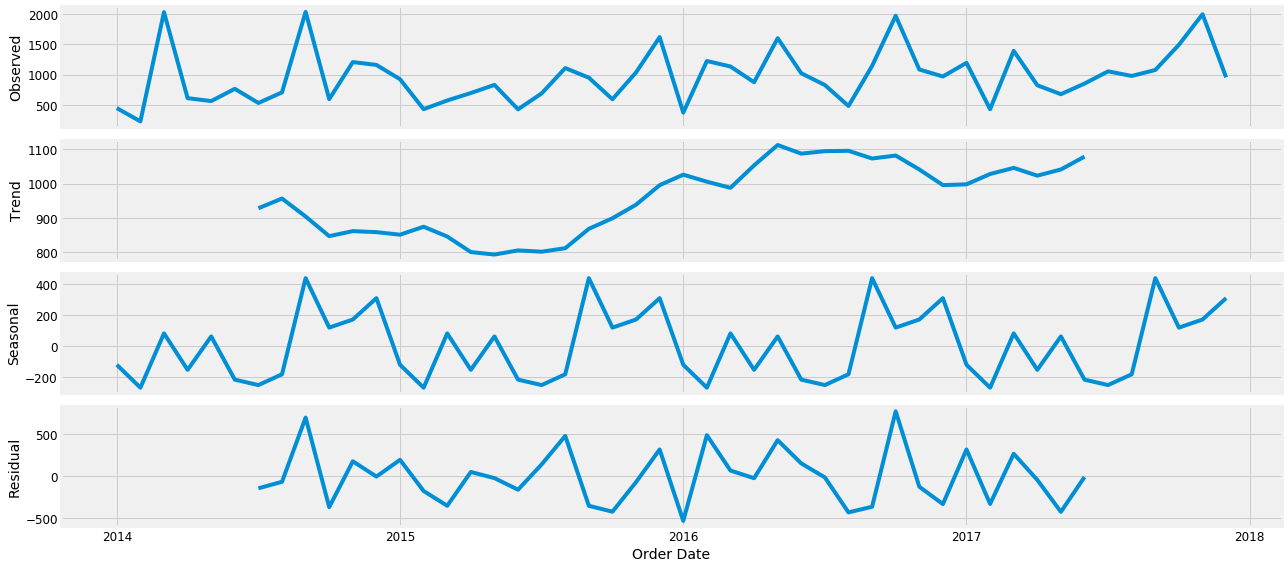

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of technolgy items are unstable, along with its obvious seasonality.

__Time series forecasting with ARIMA__

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Our goal is here to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()

            print('ARIMA{} x {}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue

ARIMA(0, 0, 0) x (0, 0, 0, 12)12 - AIC:791.4891765009955
ARIMA(0, 0, 0) x (0, 0, 1, 12)12 - AIC:1382.2460466177615
ARIMA(0, 0, 0) x (0, 1, 0, 12)12 - AIC:549.0156237882128
ARIMA(0, 0, 0) x (1, 0, 0, 12)12 - AIC:564.1031529698099
ARIMA(0, 0, 0) x (1, 0, 1, 12)12 - AIC:1484.5592884888115
ARIMA(0, 0, 0) x (1, 1, 0, 12)12 - AIC:372.6612068172691
ARIMA(0, 0, 1) x (0, 0, 0, 12)12 - AIC:750.8969484750892
ARIMA(0, 0, 1) x (0, 0, 1, 12)12 - AIC:3051.8298780187833
ARIMA(0, 0, 1) x (0, 1, 0, 12)12 - AIC:535.0489454747435
ARIMA(0, 0, 1) x (1, 0, 0, 12)12 - AIC:566.0827904028253
ARIMA(0, 0, 1) x (1, 0, 1, 12)12 - AIC:2875.8349964287036
ARIMA(0, 0, 1) x (1, 1, 0, 12)12 - AIC:373.8760065868613
ARIMA(0, 1, 0) x (0, 0, 0, 12)12 - AIC:729.3478530237927
ARIMA(0, 1, 0) x (0, 0, 1, 12)12 - AIC:1417.3994773183556
ARIMA(0, 1, 0) x (0, 1, 0, 12)12 - AIC:562.7585881087532
ARIMA(0, 1, 0) x (1, 0, 0, 12)12 - AIC:543.3082156228088
ARIMA(0, 1, 0) x (1, 0, 1, 12)12 - AIC:1449.6389188838746
ARIMA(0, 1, 0) x (1, 1, 0

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 343.60. Therefore we should consider this to be optimal option.

__Fitting the ARIMA model__

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2660      0.249     -1.067      0.286      -0.755       0.223
ma.L1         -1.0001      0.348     -2.870      0.004      -1.683      -0.317
ar.S.L12      -0.5003      0.175     -2.852      0.004      -0.844      -0.157
sigma2      2.243e+05   1.55e-06   1.44e+11      0.000    2.24e+05    2.24e+05


We should always run model diagnostics to investigate any unusual behavior.

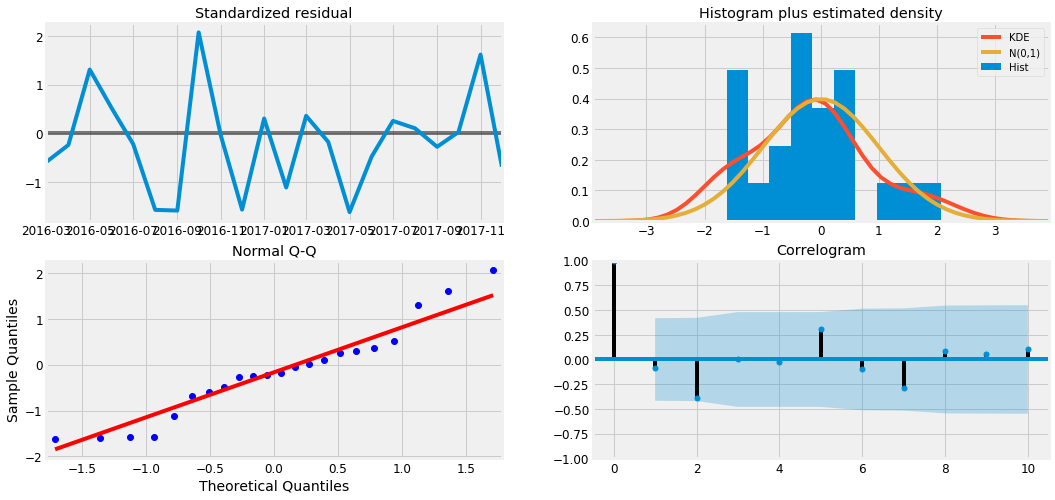

In [14]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

__Validating Forecast__

To help us understand, the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

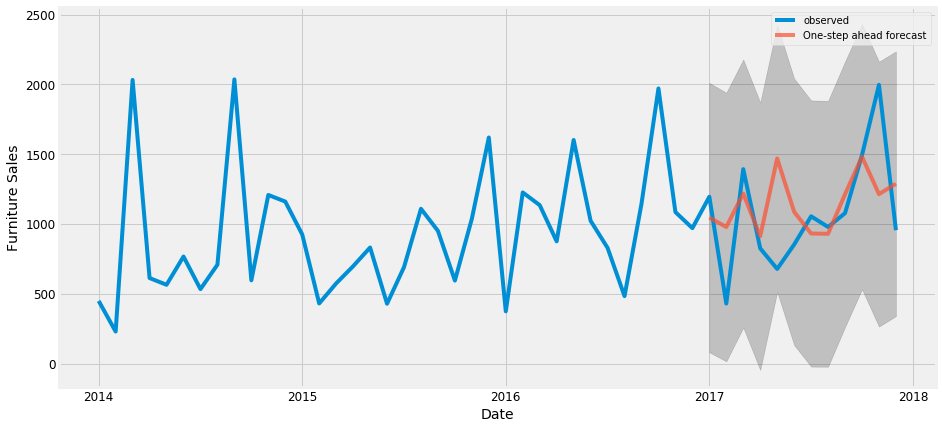

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, alpha=0.7, label='One-step ahead forecast', figsize=(14,7))

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values nearly well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2014':]

mse = ((y_forecasted - y_truth)**2).mean()
print('The mean squared error of our forecast is {}'.format(round(mse,2)))

The mean squared error of our forecast is 150095.64


In [17]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 387.42


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 387.42 of the real sales. Our furniture daily sales range from around 400 to over 1600. In my opinion, this is a pretty good model so far.

__Producing and visualizing forecasts__

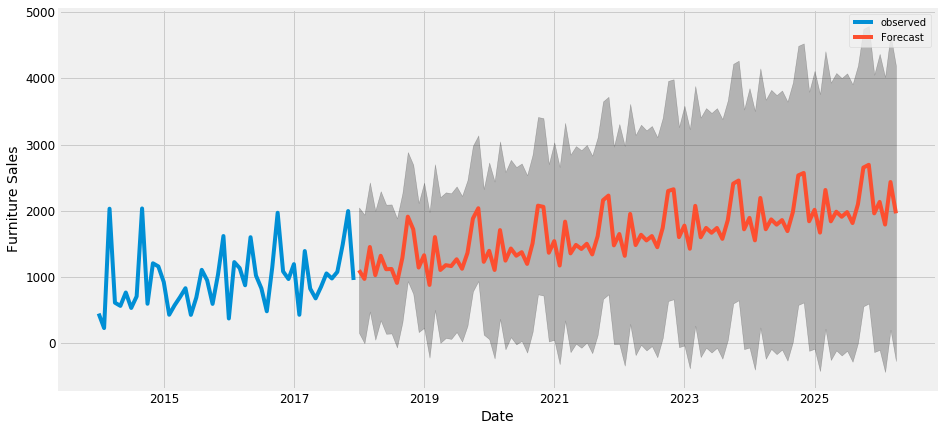

In [18]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()